In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd

# Path to dataset
data_dir = r'C:\Users\chinm\Downloads\emotion_recog'

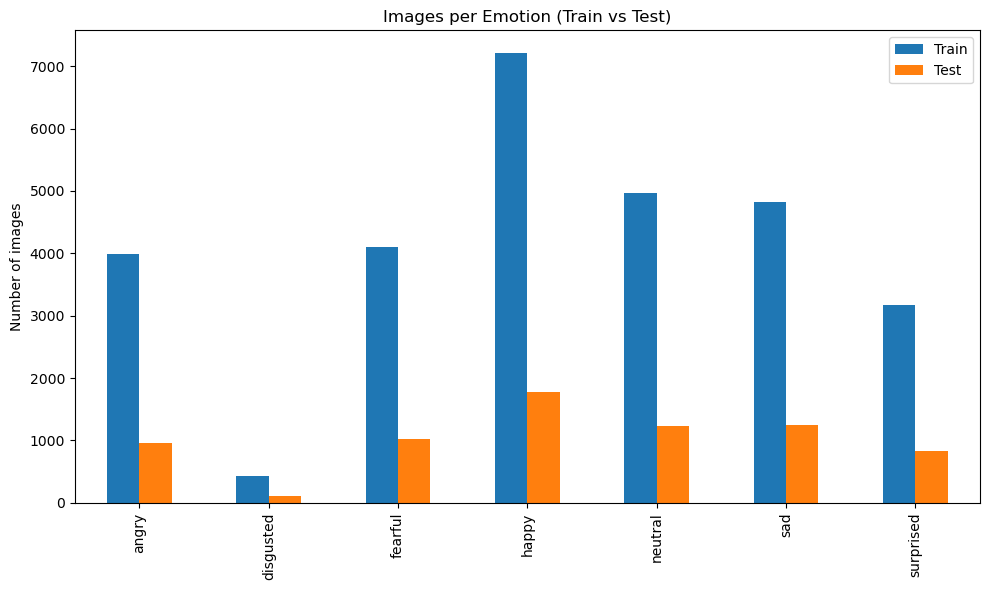

In [4]:
def count_images(directory):
    emotion_counts = {}
    for emotion in os.listdir(directory):
        folder_path = os.path.join(directory, emotion)
        if os.path.isdir(folder_path):
            count = len(os.listdir(folder_path))
            emotion_counts[emotion] = count
    return emotion_counts

train_counts = count_images(os.path.join(data_dir, 'train'))
test_counts = count_images(os.path.join(data_dir, 'test'))

# Combine into DataFrame
df_counts = pd.DataFrame([train_counts, test_counts], index=['Train', 'Test']).T
df_counts.plot(kind='bar', figsize=(10,6), title="Images per Emotion (Train vs Test)")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

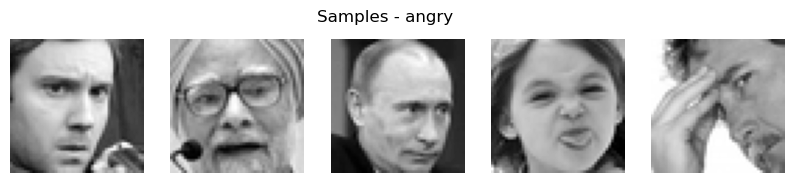

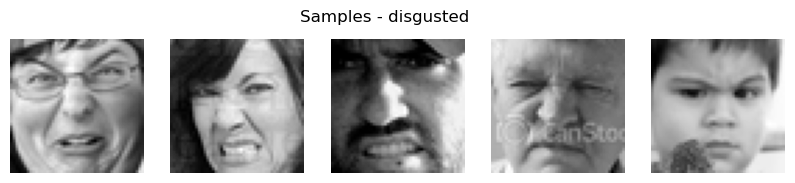

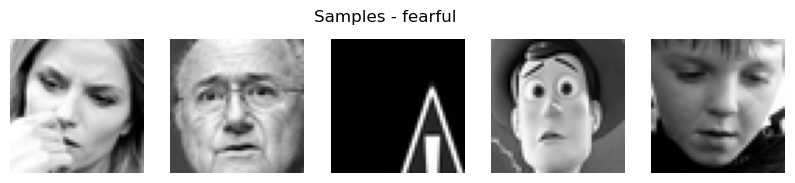

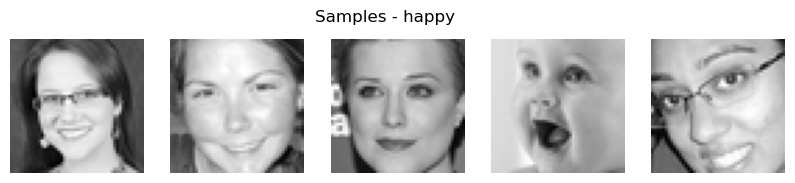

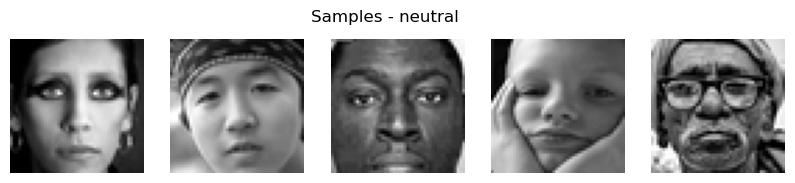

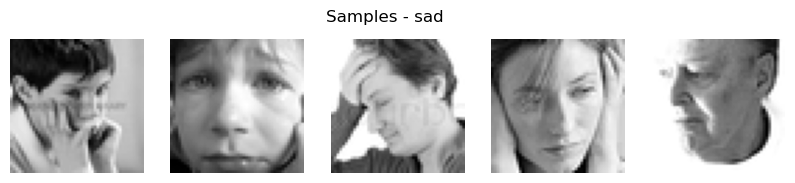

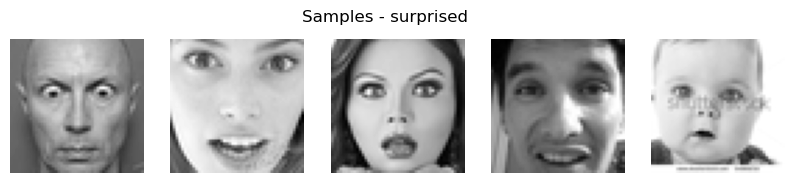

In [5]:
def plot_sample_images(directory, emotion, num_images=5):
    folder = os.path.join(directory, emotion)
    images = os.listdir(folder)[:num_images]
    plt.figure(figsize=(10, 2))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path).convert('L')
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Samples - {emotion}")
    plt.show()

# Example
for emotion in train_counts.keys():
    plot_sample_images(os.path.join(data_dir, 'train'), emotion)

Unique image sizes: {(48, 48)}


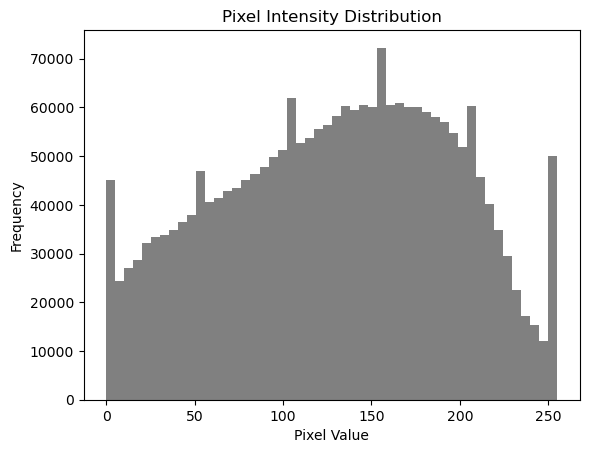

In [6]:
def analyze_images(directory, sample_size=1000):
    sizes = []
    intensities = []

    for emotion in os.listdir(directory):
        folder = os.path.join(directory, emotion)
        if os.path.isdir(folder):
            for img_file in os.listdir(folder)[:sample_size // 7]:  # roughly balanced sample
                img = Image.open(os.path.join(folder, img_file)).convert('L')
                sizes.append(img.size)
                intensities.extend(np.array(img).flatten())

    return sizes, intensities

sizes, intensities = analyze_images(os.path.join(data_dir, 'train'))

# Size distribution
print("Unique image sizes:", set(sizes))

# Pixel intensity histogram
plt.hist(intensities, bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [7]:
mean_intensity = np.mean(intensities)
std_intensity = np.std(intensities)
print(f"Mean pixel intensity: {mean_intensity:.2f}")
print(f"Standard deviation: {std_intensity:.2f}")

Mean pixel intensity: 129.77
Standard deviation: 65.20



Unique image sizes found: 1

Size (48, 48): 35887 images


C:\Users\chinm\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


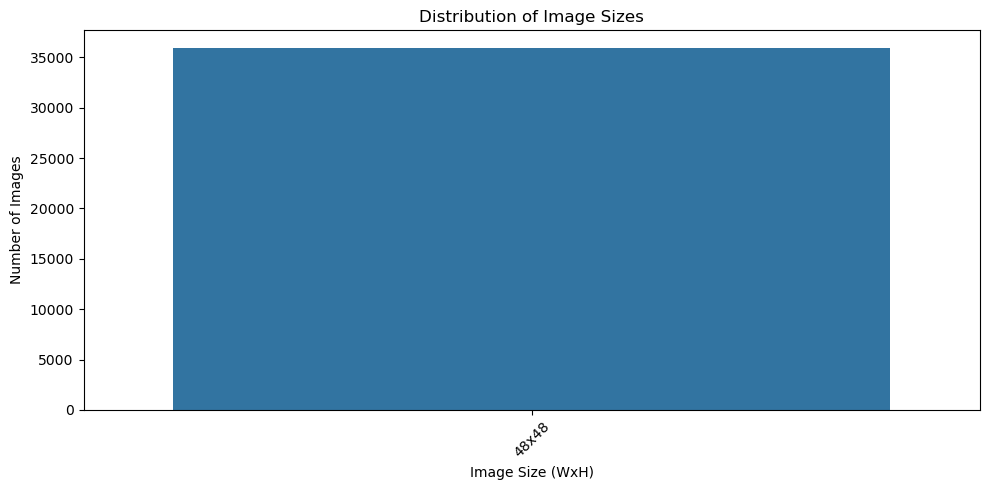

In [10]:
from collections import Counter

def get_image_sizes(root_dir):
    sizes = []
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        for emotion in os.listdir(split_dir):
            emotion_dir = os.path.join(split_dir, emotion)
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                try:
                    img = Image.open(img_path)
                    sizes.append(img.size)  # (width, height)
                except:
                    print(f"Error loading image: {img_path}")
    return sizes

# Run the function
all_sizes = get_image_sizes(r'C:\Users\chinm\Downloads\emotion_recog')

# Count unique sizes
size_counts = Counter(all_sizes)

# Print summary
print(f"\nUnique image sizes found: {len(size_counts)}\n")
for size, count in size_counts.items():
    print(f"Size {size}: {count} images")

# Optional: plot distribution of sizes
size_labels = [f"{w}x{h}" for (w, h) in size_counts.keys()]
size_values = list(size_counts.values())

plt.figure(figsize=(10, 5))
sns.barplot(x=size_labels, y=size_values)
plt.title("Distribution of Image Sizes")
plt.xlabel("Image Size (WxH)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
from PIL import Image, UnidentifiedImageError

def find_corrupted_images(root_dir):
    corrupted = []
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        for emotion in os.listdir(split_dir):
            emotion_dir = os.path.join(split_dir, emotion)
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                try:
                    img = Image.open(img_path)
                    img.verify()  # Check for corruption
                except (UnidentifiedImageError, IOError, OSError):
                    corrupted.append(img_path)
    return corrupted

# Run the check
corrupted_images = find_corrupted_images(r'C:\Users\chinm\Downloads\emotion_recog')
print(f"Found {len(corrupted_images)} corrupted images.")
for path in corrupted_images:
    print(path)

Found 0 corrupted images.


In [12]:
def find_low_variance_images(root_dir, threshold=5):
    low_var_images = []
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        for emotion in os.listdir(split_dir):
            emotion_dir = os.path.join(split_dir, emotion)
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                try:
                    img = Image.open(img_path).convert('L')
                    arr = np.array(img)
                    if arr.std() < threshold:
                        low_var_images.append(img_path)
                except:
                    continue
    return low_var_images

low_var_images = find_low_variance_images(r'C:\Users\chinm\Downloads\emotion_recog')
print(f"Found {len(low_var_images)} low-variance (possibly blank/noisy) images.")

Found 14 low-variance (possibly blank/noisy) images.


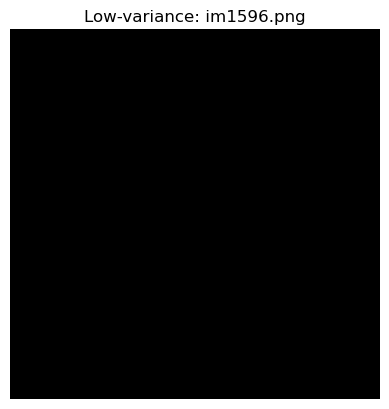

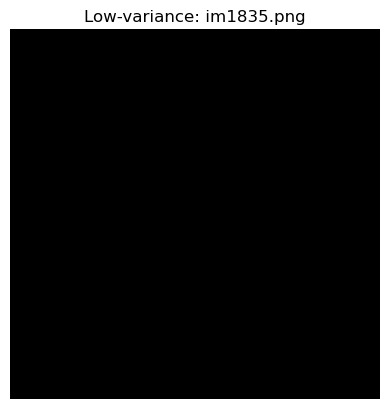

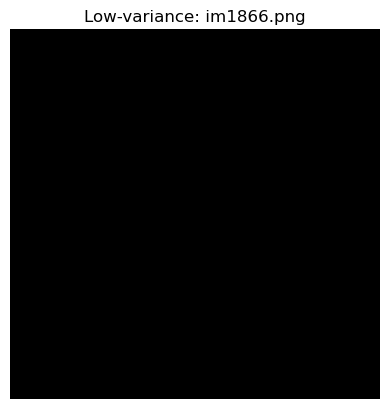

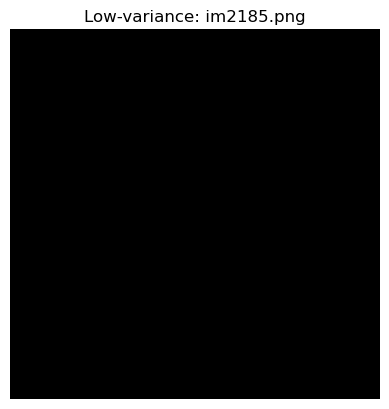

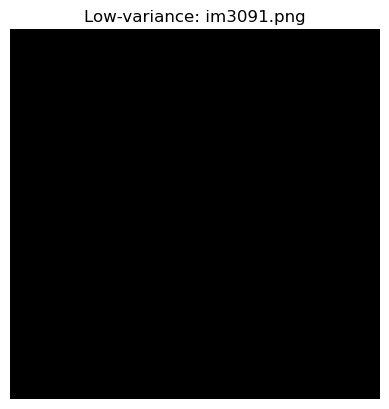

In [13]:
for path in low_var_images[:5]:
    img = Image.open(path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Low-variance: {os.path.basename(path)}")
    plt.axis('off')
    plt.show()

In [19]:
def delete_low_variance_images(image_paths):
    deleted = 0
    for img_path in image_paths:
        try:
            os.remove(img_path)
            print(f"Deleted: {img_path}")
            deleted += 1
        except Exception as e:
            print(f"Failed to delete {img_path}: {e}")
    print(f"\nSuccessfully deleted {deleted}/{len(image_paths)} low-variance images.")

In [17]:
import os

def count_images_per_class(data_dir):
    stats = {}
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        if not os.path.exists(split_dir):
            print(f"[!] Directory not found: {split_dir}")
            continue

        print(f"\n📁 {split.upper()} DATA:")
        for emotion in sorted(os.listdir(split_dir)):
            emotion_dir = os.path.join(split_dir, emotion)
            if not os.path.isdir(emotion_dir):
                continue  # skip non-folder files

            # Count only image files
            image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            num_images = len(image_files)

            stats[(split, emotion)] = num_images
            print(f"{emotion:<10}: {num_images} images")
    return stats

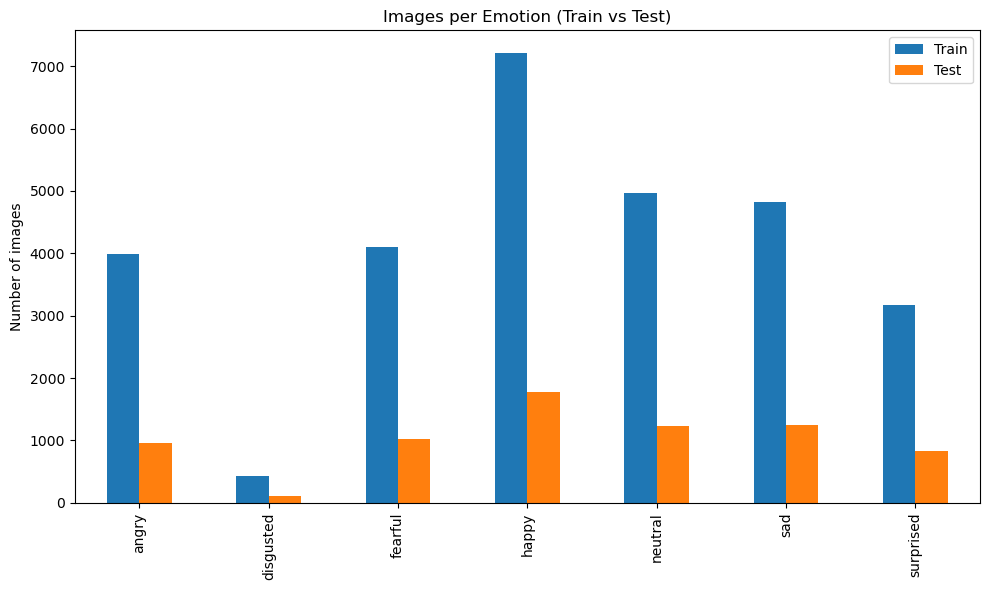

In [18]:
def count_images(directory):
    emotion_counts = {}
    for emotion in os.listdir(directory):
        folder_path = os.path.join(directory, emotion)
        if os.path.isdir(folder_path):
            count = len(os.listdir(folder_path))
            emotion_counts[emotion] = count
    return emotion_counts

train_counts = count_images(os.path.join(data_dir, 'train'))
test_counts = count_images(os.path.join(data_dir, 'test'))

# Combine into DataFrame
df_counts = pd.DataFrame([train_counts, test_counts], index=['Train', 'Test']).T
df_counts.plot(kind='bar', figsize=(10,6), title="Images per Emotion (Train vs Test)")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
import os
import numpy as np
from PIL import Image

# Step 1: Find low-variance (noisy/blank) images
def find_low_variance_images(root_dir, threshold=5):
    low_var_images = []
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        for emotion in os.listdir(split_dir):
            emotion_dir = os.path.join(split_dir, emotion)
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                try:
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    arr = np.array(img)
                    if arr.std() < threshold:
                        low_var_images.append(img_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue
    return low_var_images

# Step 2: Delete the low-variance images
def delete_low_variance_images(image_paths):
    deleted = 0
    for img_path in image_paths:
        if os.path.exists(img_path):
            try:
                os.remove(img_path)
                print(f"Deleted: {img_path}")
                deleted += 1
            except Exception as e:
                print(f"Failed to delete {img_path}: {e}")
        else:
            print(f"Image not found: {img_path}")
    print(f"\nSuccessfully deleted {deleted}/{len(image_paths)} low-variance images.")

# Step 3: Recount and display number of images per emotion class
def count_images_per_class(root_dir):
    stats = {}
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        if not os.path.exists(split_dir):
            print(f"[!] Directory not found: {split_dir}")
            continue

        print(f"\n📁 {split.upper()} DATA:")
        for emotion in sorted(os.listdir(split_dir)):
            emotion_dir = os.path.join(split_dir, emotion)
            if not os.path.isdir(emotion_dir):
                continue  # skip non-folder files

            # Count only image files
            image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            num_images = len(image_files)

            stats[(split, emotion)] = num_images
            print(f"{emotion:<10}: {num_images} images")
    return stats

# Main execution flow

dataset_path = r'C:\Users\chinm\Downloads\emotion_recog'

# Step 4: Identify low-variance images
low_var_images = find_low_variance_images(dataset_path)
print(f"\nFound {len(low_var_images)} low-variance (possibly blank/noisy) images.")

# Step 5: Delete low-variance images
delete_low_variance_images(low_var_images)

# Step 6: Recount and display the number of images per class
image_counts = count_images_per_class(dataset_path)



Found 14 low-variance (possibly blank/noisy) images.
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im1596.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im1835.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im1866.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im2185.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im3091.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im3975.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\angry\im930.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\happy\im1933.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\neutral\im363.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\neutral\im3977.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\sad\im1721.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\train\surprised\im1499.png
Deleted: C:\Users\chinm\Downloads\emotion_recog\test\angry\im178.png
Deleted: C:\Users\chi


📁 TRAIN DATA:


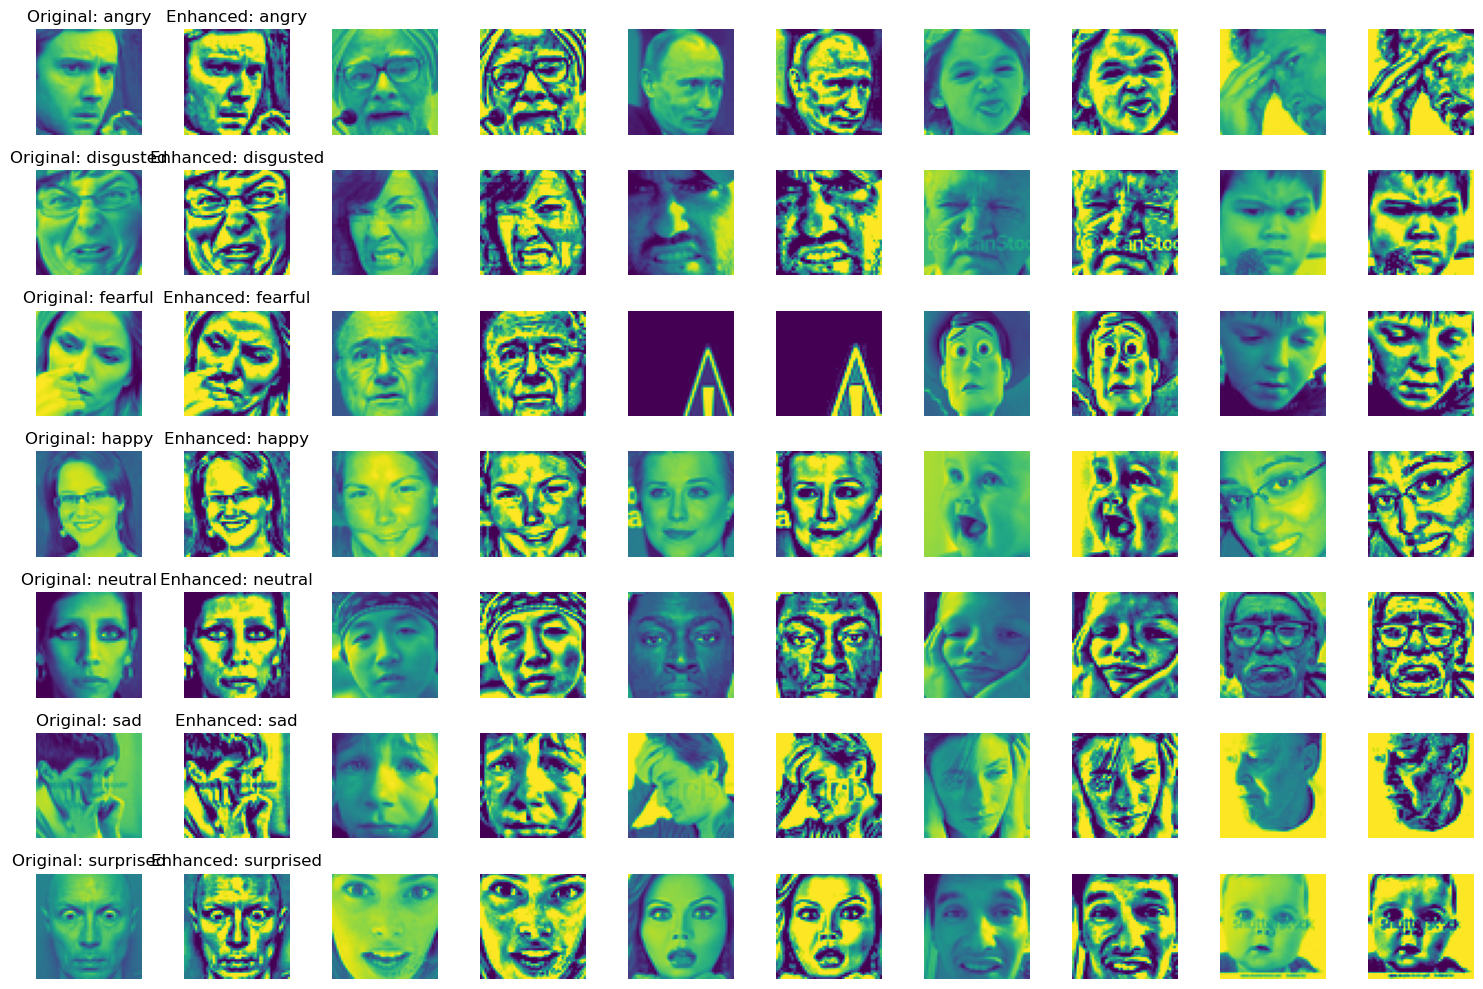


📁 TEST DATA:


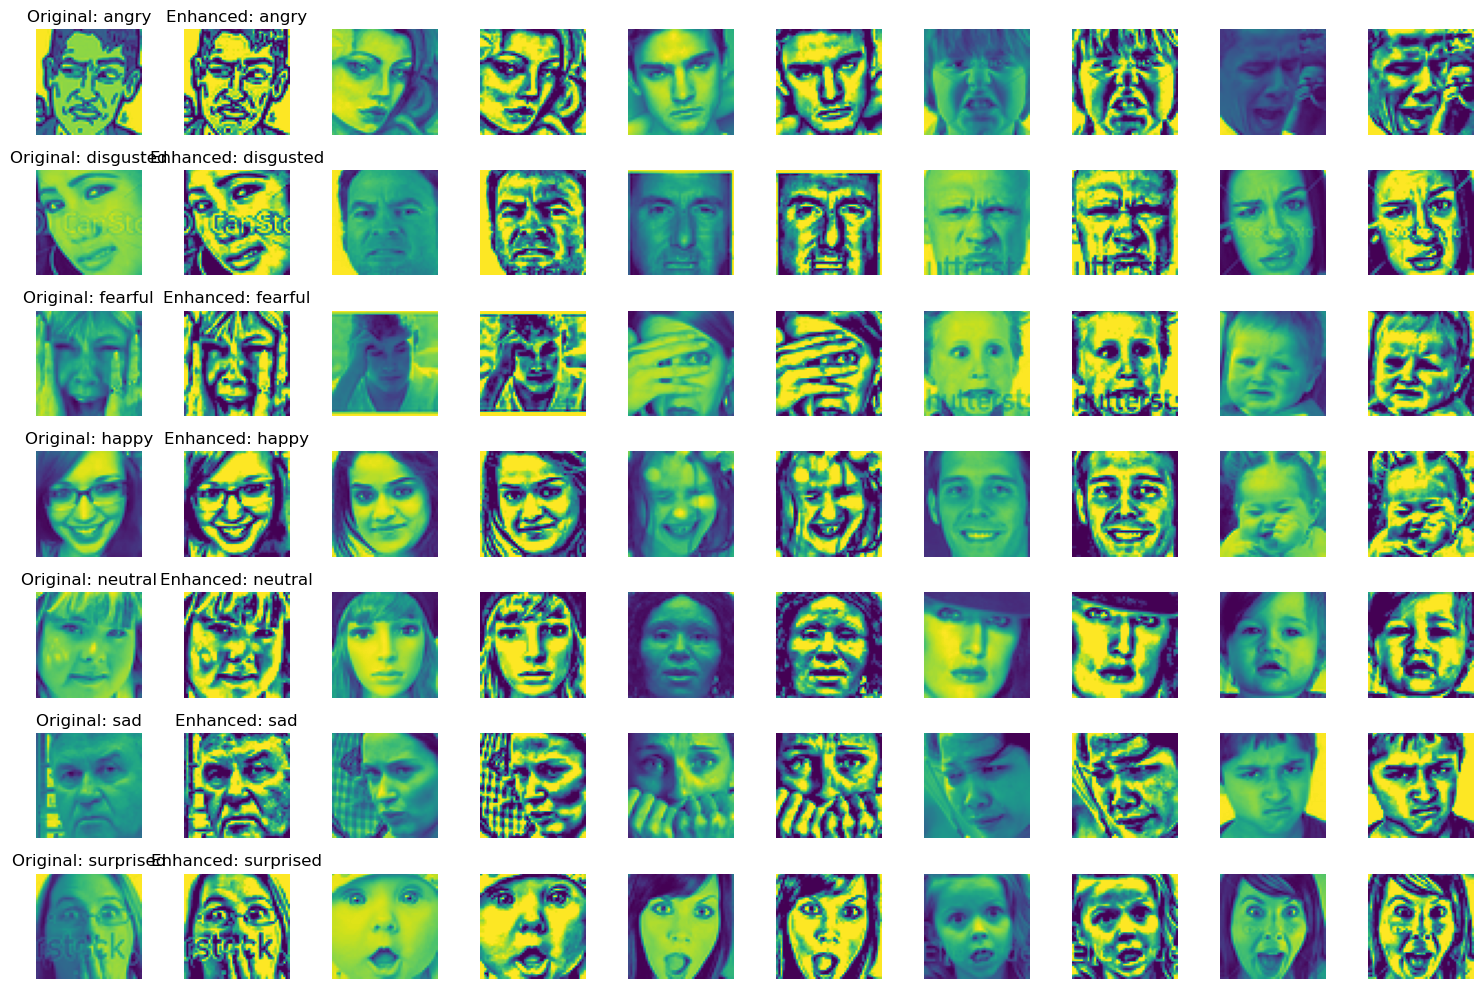

In [22]:
import os
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import cv2

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization) and Sharpening
def apply_clahe_sharpening(image):
    try:
        # Convert image to numpy array (for CLAHE processing)
        img_arr = np.array(image)

        # Check if the image is already grayscale (single channel)
        if len(img_arr.shape) == 2:
            gray = img_arr  # If already grayscale, no need to convert
        else:
            gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)

        # Apply CLAHE (on grayscale image)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        
        # Convert back to PIL image
        enhanced_img = Image.fromarray(enhanced)

        # Apply sharpening to the enhanced image
        enhancer = ImageEnhance.Contrast(enhanced_img)
        enhanced_img = enhancer.enhance(2.0)  # Sharpen the image (adjust the factor as needed)

        return enhanced_img
    except Exception as e:
        print(f"Error applying CLAHE and sharpening: {e}")
        return image  # Return the original image if there's an error

# Function to load images and apply CLAHE + Sharpening, then show before/after comparison
def process_and_visualize_images(root_dir, num_samples=5):
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        print(f"\n📁 {split.upper()} DATA:")

        # Create a plot to visualize before/after (original vs. enhanced) images
        plt.figure(figsize=(15, 10))

        for i, emotion in enumerate(sorted(os.listdir(split_dir))):
            emotion_dir = os.path.join(split_dir, emotion)
            if not os.path.isdir(emotion_dir):
                continue  # skip non-folder files

            # Get a list of image files in the emotion class folder
            image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Visualize only 'num_samples' images from this class
            for idx, img_name in enumerate(image_files[:num_samples]):
                img_path = os.path.join(emotion_dir, img_name)
                try:
                    img = Image.open(img_path)
                    
                    # Apply CLAHE and Sharpening
                    processed_img = apply_clahe_sharpening(img)

                    # Plot the original image and processed image side by side
                    # Left: Original Image
                    plt.subplot(len(os.listdir(split_dir)), num_samples * 2, i * num_samples * 2 + idx * 2 + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    if idx == 0:
                        plt.title(f"Original: {emotion}")

                    # Right: Processed Image (CLAHE + Sharpening)
                    plt.subplot(len(os.listdir(split_dir)), num_samples * 2, i * num_samples * 2 + idx * 2 + 2)
                    plt.imshow(processed_img)
                    plt.axis('off')
                    if idx == 0:
                        plt.title(f"Enhanced: {emotion}")

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

        plt.tight_layout()
        plt.show()

# Main Execution
dataset_path = r'C:\Users\chinm\Downloads\emotion_recog'
process_and_visualize_images(dataset_path)



📁 TRAIN DATA:


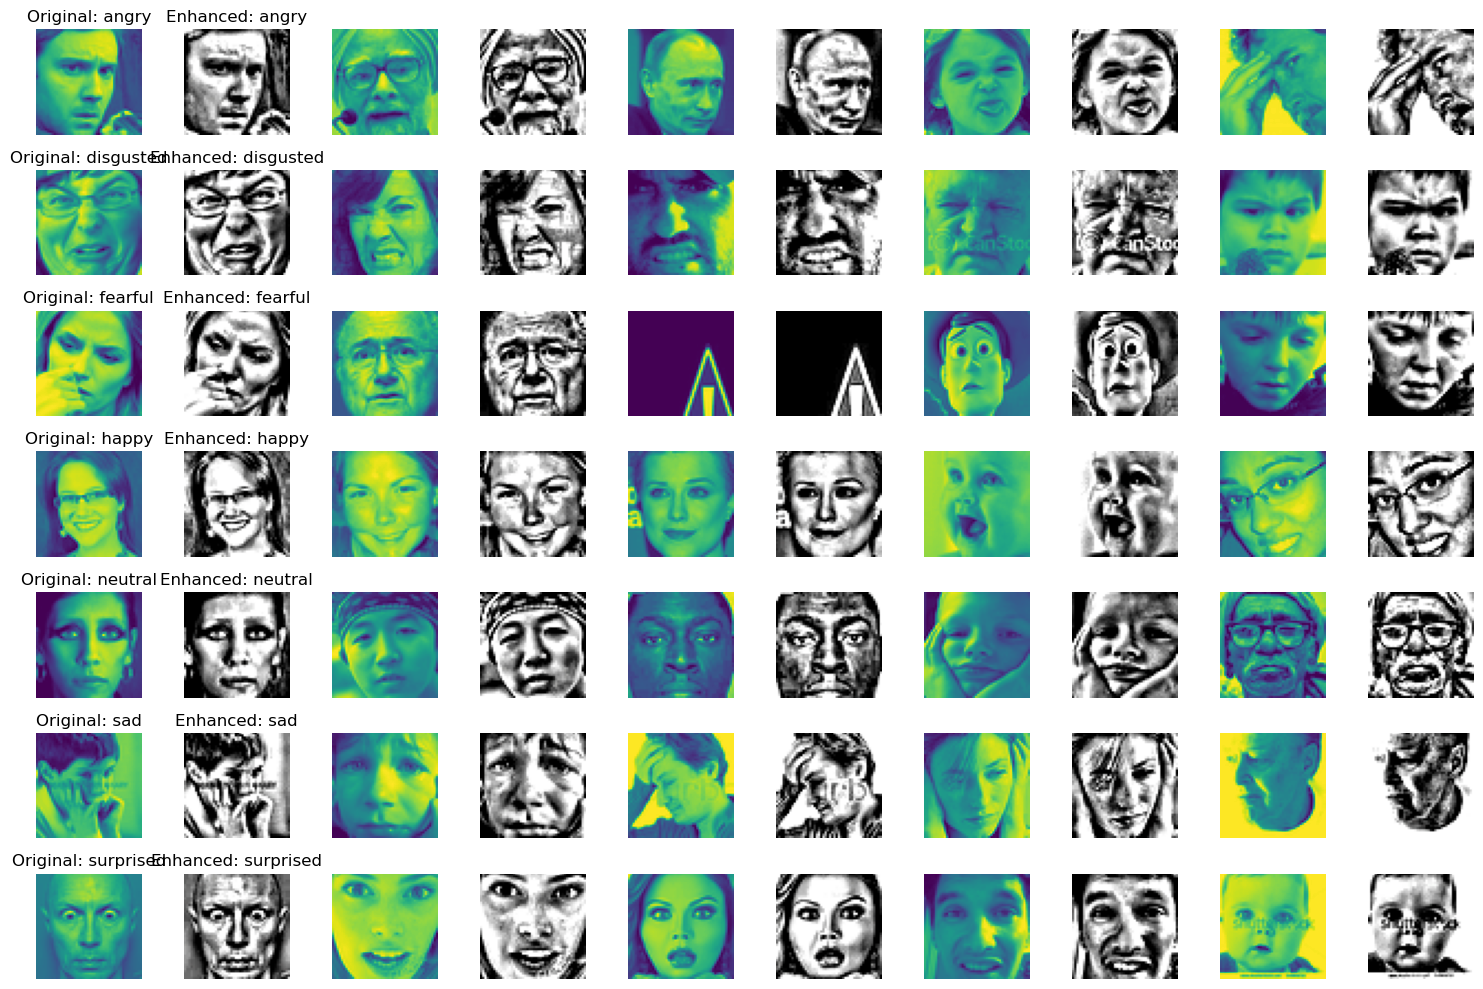


📁 TEST DATA:


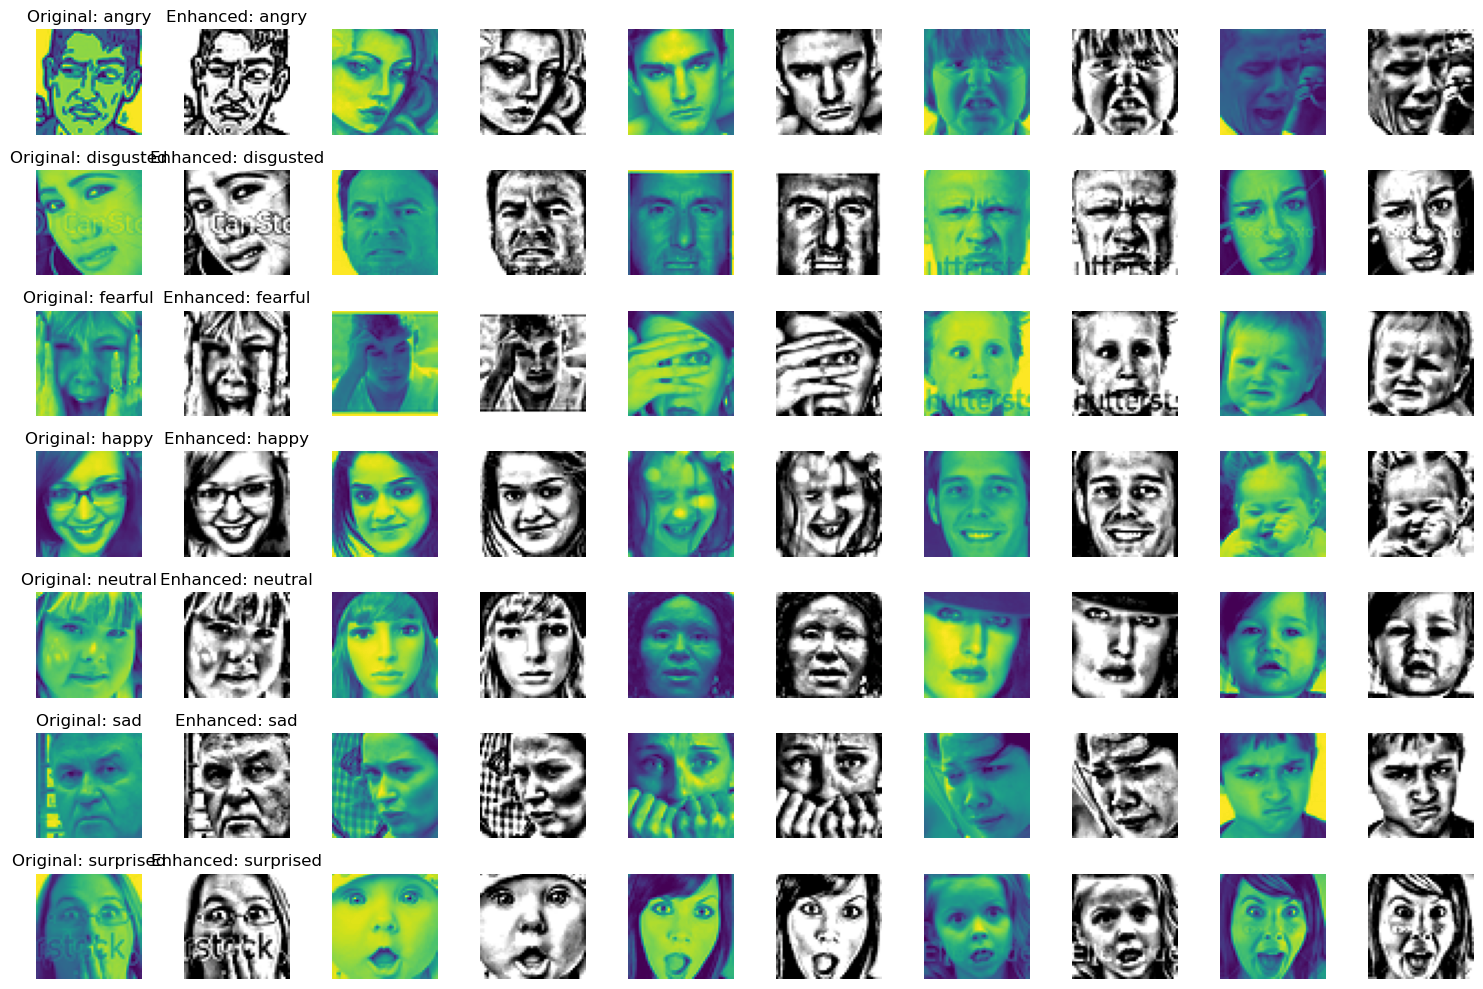

In [24]:
import os
import numpy as np
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization) and Sharpening
def apply_clahe_sharpening(image):
    try:
        # Convert image to numpy array (for CLAHE processing)
        img_arr = np.array(image)

        # Check if the image is grayscale (single channel), convert it to 3 channels (RGB)
        if len(img_arr.shape) == 2:  # Grayscale image
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
        
        # Convert image to LAB color space (L: Lightness, A and B: Color components)
        lab = cv2.cvtColor(img_arr, cv2.COLOR_RGB2LAB)

        # Apply CLAHE on the L channel (Lightness channel)
        l, a, b = cv2.split(lab)  # Split channels
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)  # Enhance only the lightness channel
        
        # Merge the CLAHE-enhanced L channel back with the A and B channels
        enhanced_lab = cv2.merge((l, a, b))

        # Convert back to RGB
        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

        # Convert back to PIL image
        enhanced_img = Image.fromarray(enhanced_img)

        # Apply sharpening to the enhanced image
        enhancer = ImageEnhance.Contrast(enhanced_img)
        enhanced_img = enhancer.enhance(2.0)  # Sharpen the image (adjust the factor as needed)

        return enhanced_img
    except Exception as e:
        print(f"Error applying CLAHE and sharpening: {e}")
        return image  # Return the original image if there's an error

# Function to load images and apply CLAHE + Sharpening, then show before/after comparison
def process_and_visualize_images(root_dir, num_samples=5):
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        print(f"\n📁 {split.upper()} DATA:")

        # Create a plot to visualize before/after (original vs. enhanced) images
        plt.figure(figsize=(15, 10))

        for i, emotion in enumerate(sorted(os.listdir(split_dir))):
            emotion_dir = os.path.join(split_dir, emotion)
            if not os.path.isdir(emotion_dir):
                continue  # skip non-folder files

            # Get a list of image files in the emotion class folder
            image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Visualize only 'num_samples' images from this class
            for idx, img_name in enumerate(image_files[:num_samples]):
                img_path = os.path.join(emotion_dir, img_name)
                try:
                    img = Image.open(img_path)
                    
                    # Apply CLAHE and Sharpening
                    processed_img = apply_clahe_sharpening(img)

                    # Plot the original image and processed image side by side
                    # Left: Original Image
                    plt.subplot(len(os.listdir(split_dir)), num_samples * 2, i * num_samples * 2 + idx * 2 + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    if idx == 0:
                        plt.title(f"Original: {emotion}")

                    # Right: Processed Image (CLAHE + Sharpening)
                    plt.subplot(len(os.listdir(split_dir)), num_samples * 2, i * num_samples * 2 + idx * 2 + 2)
                    plt.imshow(processed_img)
                    plt.axis('off')
                    if idx == 0:
                        plt.title(f"Enhanced: {emotion}")

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

        plt.tight_layout()
        plt.show()

# Main Execution
dataset_path = r'C:\Users\chinm\Downloads\emotion_recog'
process_and_visualize_images(dataset_path)


In [25]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def save_enhanced_images(src_dir, dest_dir, apply_clahe=True, apply_sharpening=True):
    # Create destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for split in ['train', 'test']:
        split_dir = os.path.join(src_dir, split)
        for emotion in os.listdir(split_dir):
            emotion_dir = os.path.join(split_dir, emotion)
            dest_emotion_dir = os.path.join(dest_dir, split, emotion)
            if not os.path.exists(dest_emotion_dir):
                os.makedirs(dest_emotion_dir)

            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)

                try:
                    # Open image
                    img = Image.open(img_path)
                    img = img.convert('RGB')  # Ensure it's in RGB format

                    # Apply CLAHE and sharpening if needed
                    img_np = np.array(img)
                    if apply_clahe:
                        img_np = apply_clahe_to_image(img_np)
                    if apply_sharpening:
                        img_np = apply_sharpening_to_image(img_np)

                    # Save enhanced image
                    enhanced_img = Image.fromarray(img_np)
                    enhanced_img.save(os.path.join(dest_emotion_dir, img_name))

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

def apply_clahe_to_image(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge back the LAB channels and convert to RGB
    limg = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced_image

def apply_sharpening_to_image(image):
    # Define sharpening kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])

    # Apply filter to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image

# Set the source and destination directories
src_dir = r'C:\Users\chinm\Downloads\emotion_recog'  # Original dataset location
dest_dir = r'C:\Users\chinm\Downloads\enhanced_emotion_recog'  # New location for enhanced images

# Save the enhanced images
save_enhanced_images(src_dir, dest_dir)

print("Enhancement complete. Enhanced images saved to:", dest_dir)


Enhancement complete. Enhanced images saved to: C:\Users\chinm\Downloads\enhanced_emotion_recog
